In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime

In [10]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [12]:
to_drop=["outside_diameter","wall_thickness","raised_face_depth","w_neck_c", "flange_outer_radius", "flange_thickness_d",
        "raised_face_radius", "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"]
data.drop(columns=to_drop,inplace=True)

In [13]:
data.dtypes

pipe_dn                     int64
pipe_schedule              object
flange_class                int64
length1                   float64
length2                   float64
lumped_mass               float64
frequency                 float64
x_deformation_position    float64
y_deformation_position    float64
z_deformation_position    float64
support                    object
allowable_deformation     float64
dtype: object

In [14]:
numeric_features = ['pipe_dn','flange_class', 'length1', 'length2', 'lumped_mass',
                    ]
categorical_features = ['pipe_schedule', 'support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [15]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [16]:
target_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(target_columns, axis=1)
y = data[target_columns]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [18]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [19]:
scaler_y = StandardScaler()
y_train_transformed = scaler_y.fit_transform(y_train)
y_test_transformed = scaler_y.transform(y_test)

In [20]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [21]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(64, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(16, activation='relu')(dropout2)

# Separate output for each target variable
output_allowable_deformation = Dense(1, name='allowable_deformation')(hidden3)
output_frequency = Dense(1, name='frequency')(hidden3)
output_x_position = Dense(1, name='x_deformation_position')(hidden3)
output_y_position = Dense(1, name='y_deformation_position')(hidden3)
output_z_position = Dense(1, name='z_deformation_position')(hidden3)

In [22]:
model = Model(inputs=input_layer, outputs=[output_allowable_deformation, output_frequency, 
                                           output_x_position, output_y_position, output_z_position])

In [23]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              loss_weights=[1.0, 1.0, 1.0, 1.0, 1.0])

In [24]:
history = model.fit(
    x_train_transformed, 
    [y_train_transformed[:, i] for i in range(5)],  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - allowable_deformation_loss: 1.0485 - frequency_loss: 0.9037 - loss: 4.8624 - x_deformation_position_loss: 0.9401 - y_deformation_position_loss: 0.9662 - z_deformation_position_loss: 1.0040 - val_allowable_deformation_loss: 0.6047 - val_frequency_loss: 0.6068 - val_loss: 3.0643 - val_x_deformation_position_loss: 0.2559 - val_y_deformation_position_loss: 0.7331 - val_z_deformation_position_loss: 0.8653
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - allowable_deformation_loss: 0.4747 - frequency_loss: 0.5402 - loss: 3.0936 - x_deformation_position_loss: 0.3140 - y_deformation_position_loss: 0.7811 - z_deformation_position_loss: 0.9836 - val_allowable_deformation_loss: 0.3362 - val_frequency_loss: 0.3996 - val_loss: 2.2484 - val_x_deformation_position_loss: 0.0970 - val_y_deformation_position_loss: 0.5600 - val_z_deformation_position_loss: 0.8537
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - allowable_deformation_los

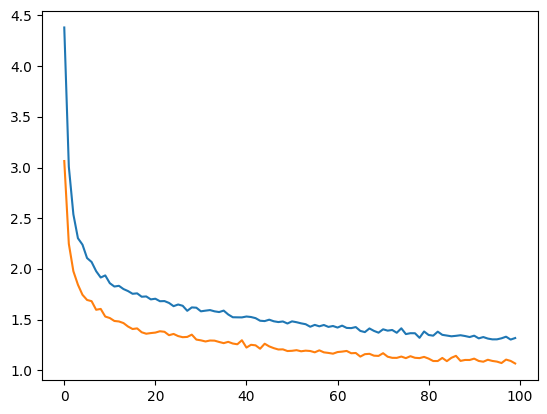

In [25]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [26]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y.inverse_transform(np.column_stack(predictions_scaled))

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [28]:
predictions_df = pd.DataFrame(predictions, columns=target_columns)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
   allowable_deformation  frequency  x_deformation_position  \
0              21.704090  93.524239              321.355621   
1               6.452594  33.105045             -531.005066   
2              28.569530  11.377124            -3126.204834   
3              10.634105  13.689778             -664.108276   
4            1293.462646   0.211510             -880.207397   

   y_deformation_position  z_deformation_position  
0               49.448387               51.190491  
1                1.228795               14.841487  
2              159.899490               -2.839217  
3                0.761027               46.031376  
4               35.274761              -12.577331  


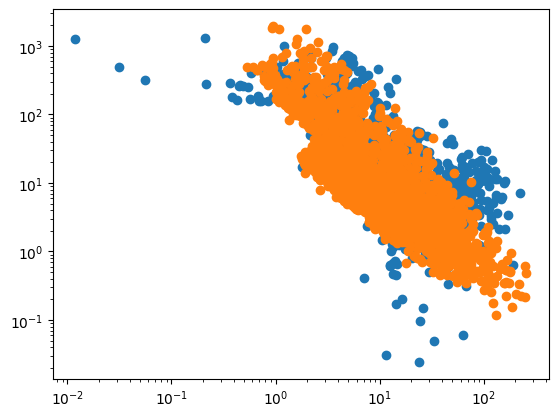

In [29]:
x=predictions_df["frequency"]
y=predictions_df["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
x=y_test["frequency"]
y=y_test["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
plt.show()

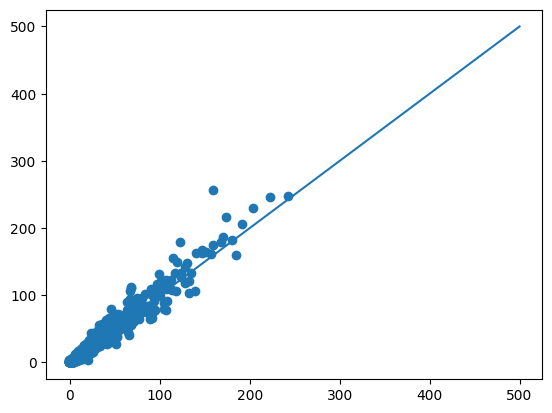

In [30]:
x=predictions_df["frequency"]
y=y_test["frequency"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 500],[0, 500])
plt.show()

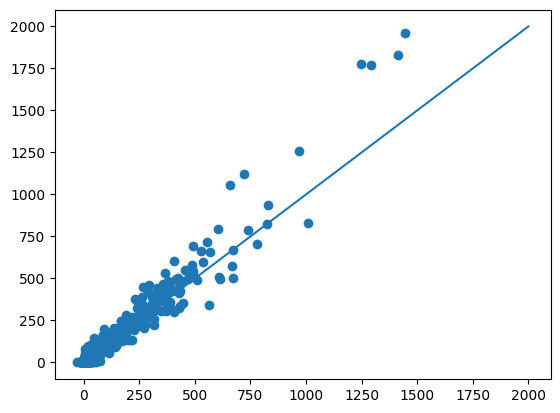

In [31]:
x=predictions_df["allowable_deformation"]
y=y_test["allowable_deformation"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 2000],[0, 2000])
plt.show()

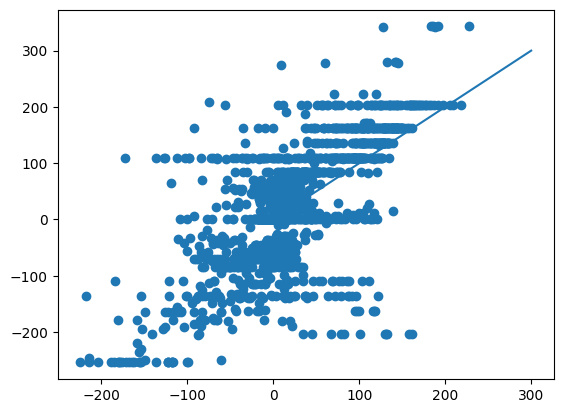

In [32]:

x=predictions_df["z_deformation_position"]
y=y_test["z_deformation_position"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 300],[0, 300])
plt.show()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   2.,   2.,
          5.,   6.,   5.,   7.,  22., 131., 330.,   7.]),
 array([-1293.11964648, -1247.25846581, -1201.39728514, -1155.53610447,
        -1109.67492379, -1063.81374312, -1017.95256245,  -972.09138178,
         -926.2302011 ,  -880.36902043,  -834.50783976,  -788.64665909,
         -742.78547841,  -696.92429774,  -651.06311707,  -605.2019364 ,
         -559.34075573,  -513.47957505,  -467.61839438,  -421.75721371,
         -375.89603304,  -330.03485236,  -284.17367169,  -238.31249102,
         -192.45131035,  -146.59012967,  -100.728949  ,   -54.86776833,
           -9.00658766,    36.85459302,    82.71577369]),
 <BarContainer object of 30 artists>)

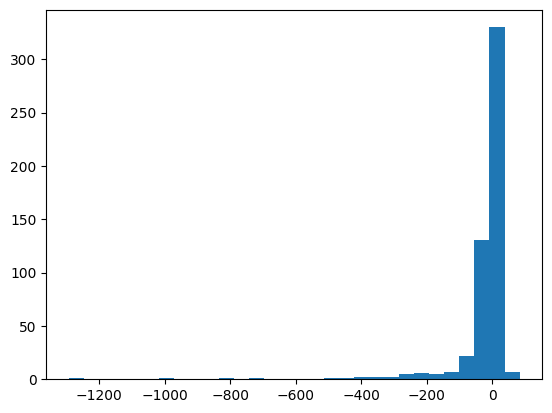

In [33]:
error= y_test["allowable_deformation"]-predictions_df["allowable_deformation"]
plt.hist(error,bins=30)

In [34]:
%load_ext tensorboard

In [35]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6008 (pid 16784), started 0:56:39 ago. (Use '!kill 16784' to kill it.)